**Name: Zahra Dehghanian**

**Student ID: 401300417**

In this practical assignment, we will develope a U-Net for semantis segmentation of lung CT-scans.

For this task, you will use a dataset consisting of CT-scans from lungs of COVID-19 patients. The regions affected by COVID-19 are marked with labels of ground glass opacity. You will be training and testing the U-Net model on this dataset.

## Imports

In [1]:
# Import any needed packages here
import torch
import numpy as np
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
import cv2
from torch import nn
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image

## Prepare Data
Now download and unzip the data. (Note: If you face any problems for downloading uzing gdown and unzipping, you may also download the data manually using the Goggle Drive links in the code)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount=True)

Mounted at /content/gdrive


In [3]:
import zipfile

zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/images.zip", "r")
zip_ref.extractall()
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/masks.zip", "r")
zip_ref.extractall()
zip_ref.close()
images = np.load('images_medseg.npy').astype(np.float32)
masks = np.load('masks_medseg.npy').astype(np.float32)

In [101]:
print("Images Shape:", images.shape)
print("Masks Shape:", masks.shape)

Images Shape: (100, 512, 512, 1)
Masks Shape: (100, 512, 512, 4)


The dataset consists of 100 CT images with size 512*512. In the Masks data,for each image 4 masks are provided with different meanings. The first mask (index 0) is the ground glass opacity class, indicating the regions affected by COVID-19. Also, the last mask (index 4) is the background class.

You can see the visulaiztion of a few of the CT images, and their given masks using the code below. In this assignment, use the first mask (ground glass opacity) for the segmentation task (You may also test it on other classes if you like too!)

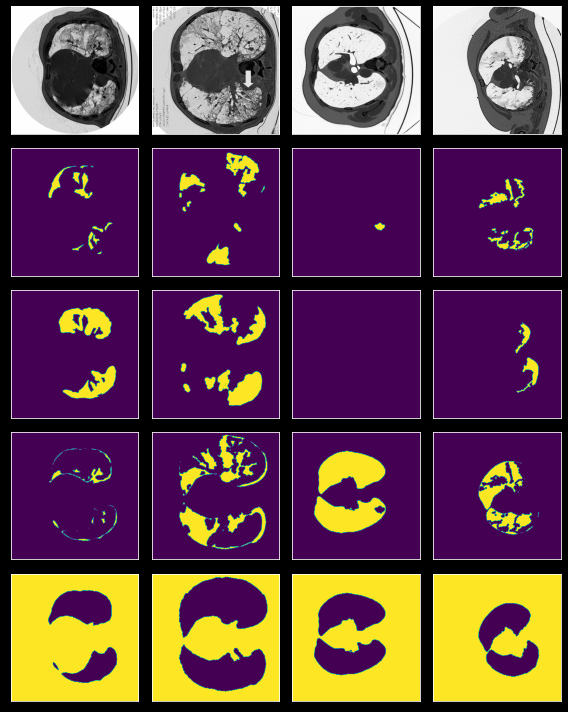

In [102]:
import matplotlib.pyplot as plt

plt.style.use("dark_background")

def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=4):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))
    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap="Greys")
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    #print(j)
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()


visualize(images, masks)

## Create Your Dataset Class (10%)

In [191]:
class CovidCTDataset(Dataset):

    def __init__(self, images,masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = self.images[idx]
        label = self.masks[idx]
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img = np.array(Image.fromarray(np.uint8(img*255)).resize((224,224)).convert('RGB'))
        # label =np.expand_dims(np.array(Image.fromarray(np.uint8(label*255)).resize((224,224))),axis = 0)
        label =np.expand_dims(np.array(Image.fromarray(np.uint8(label)).resize((224,224))), axis=0)
        return torch.from_numpy(img.transpose((2, 0, 1))).float() , torch.from_numpy(label).float()


covidDataset = CovidCTDataset(images[:,:,:,0],masks[:,:,:,0])
print(covidDataset.images.shape)
print(covidDataset.masks.shape)

(100, 512, 512)
(100, 512, 512)


## Split Dataset and Dataloader (5%)

In this part, split the dataset (80% train, 10% validation, 10% test). Then, create your train and validation DataLoader, using random shuffle and batch size of 4.

In [192]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

batch_size = 5
train_split = 0.8
valid_split = 0.1

# Create indices for the split
dataset_size = len(covidDataset)
train_size = int(train_split * dataset_size)
valid_size = int(valid_split * dataset_size)
test_size =  dataset_size - train_size - valid_size

# Split the train and validation data and create dataloaders
train_dst,valid_dst,test_dst = random_split(covidDataset, [train_size,valid_size, test_size])
train_loader = DataLoader(train_dst,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_dst,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dst,batch_size=batch_size,shuffle=True)


In [193]:
# testing one pass
xb, yb = next(iter(train_loader))
print(xb.shape, yb.shape)
print(xb.dtype, yb.dtype)


torch.Size([5, 3, 224, 224]) torch.Size([5, 1, 224, 224])
torch.float32 torch.float32


## Implement your U-Net (45%)

In this section implement your U-Net model, inherited from torch.nn.Module.

In the next text cell, explain the architecture of the implemented U-Net. Then, complete the code cell to creat your class.

In this part we implement a Unet with 4 contraction and expandition block. here we use the structure explained bellow for each block.  
contract block contains : conv2d => batchNorm2d => Relu => conv2d => batchNorm2d => Relu => Maxpool2d

expand block contains : conv2d => batchNorm2d => Relu => conv2d => batchNorm2d => Relu => ConvTranspose2d



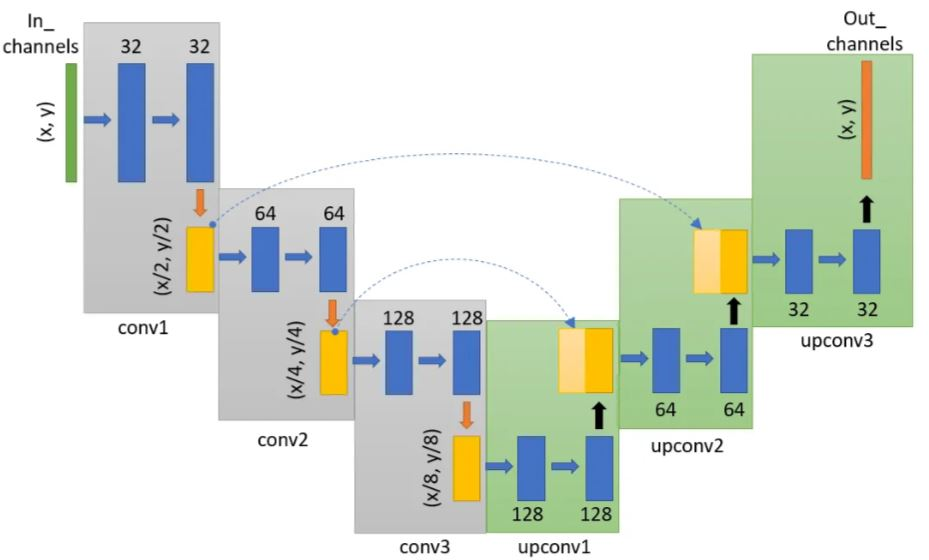

In [276]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):

        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, 16, 3, 1)

        self.outputs = nn.Conv2d(16,out_channels, kernel_size=3, padding=1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        outputs = self.outputs(upconv1)

        return torch.sigmoid(outputs)

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

## Define your model, optimizer, and loss function (5%)

Instantiate your model. Also, set your optimizer to Adam optimizer, and your criterion to Bincry Cross-Entropy Loss.

In [277]:
unet = UNET(3,1)
loss_fn = nn.BCELoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.0001)

In [278]:
pred = unet(xb)
pred.shape

torch.Size([5, 1, 224, 224])

## IOU (5%)
In this section, implement the function calculating IOU (Intersection Over Union) for a given prediction (your model's output) and target (ground-truth labels).

In [288]:
def make_binary(t):
  min, max = torch.min(t), torch.max(t)
  l = max-min
  t  = (t-min)/l
  image = torch.round(t)
  return image

In [290]:
def acc_metric(predb, yb):
    predb = make_binary(predb)
    # predb = torch.round(predb)
    return (predb == yb).float().mean()
def iou_metric(yb_p, yb):
    yb_p = make_binary(yb_p)
    # yb_p = torch.round(yb_p)
    yb = (yb==1)
    yb_p = (yb_p==1)
    intersection = np.count_nonzero(np.logical_and(yb , yb_p))
    yb =  np.count_nonzero(yb)
    yb_p =  np.count_nonzero(yb_p) 
    Iou = 0.0
    Iou = intersection  /( yb+ yb_p - intersection)
    return Iou

## Train and test function (25%)

Train your model for a desired number of epochs (at least 15). At each epoch, run your model on the validation data (reporting the loss and IOU value), and save the model which has the best average IOU on the validation set. Finally, report the average IOU on the target data.

During training, also plot the train loss values, average IOU on the train data, and avergae IOU on the validation data per epochs.

In [291]:
import time
from IPython.display import clear_output
torch.set_printoptions(precision=2)

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, iou_fn, epochs=1):
    start = time.time()
    train_loss, valid_loss = [], []
    train_iou, valid_iou = [], []
    best_acc = 0.0
    for epoch in range(epochs):
        print('-' * 20,">>>>>>>>>>>>")
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)
        for phase in ['train', 'valid']:
            running_loss = 0.0
            running_acc = 0.0
            running_iou = 0.0
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_loader
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_loader
            step = 0
            for x, y in dataloader:
                step += 1
                if phase == 'train':
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn((outputs), y)
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y)

                iou = iou_fn(outputs,y)
                acc = acc_fn(outputs, y)
                running_iou  += iou*dataloader.batch_size
                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)
            epoch_iou = running_iou / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {} iou: {}'.format(phase, epoch_loss, epoch_acc,epoch_iou))
            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)
            train_iou.append(epoch_iou) if phase=='train' else valid_iou.append(epoch_iou)
            
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss,train_iou,valid_iou, model

train_loss, valid_loss,train_iou,valid_iou,unet = train(unet, train_loader, valid_loader, loss_fn, opt, acc_metric, iou_metric, epochs=50)

-------------------- >>>>>>>>>>>>
Epoch 0/14
----------
train Loss: 0.5957 Acc: 0.6760517954826355 iou: 0.106850452983635
valid Loss: 0.5759 Acc: 0.8017618060112 iou: 0.12464945049291014
-------------------- >>>>>>>>>>>>
Epoch 1/14
----------
train Loss: 0.5570 Acc: 0.8235344886779785 iou: 0.1576533997830603
valid Loss: 0.5323 Acc: 0.8742666244506836 iou: 0.21774736161331099
-------------------- >>>>>>>>>>>>
Epoch 2/14
----------
train Loss: 0.5131 Acc: 0.8227710723876953 iou: 0.16551154129439938
valid Loss: 0.4851 Acc: 0.8790696859359741 iou: 0.226882640773889
-------------------- >>>>>>>>>>>>
Epoch 3/14
----------
train Loss: 0.4667 Acc: 0.7781980633735657 iou: 0.15286771275519792
valid Loss: 0.4357 Acc: 0.7697285413742065 iou: 0.16398160887005658
-------------------- >>>>>>>>>>>>
Epoch 4/14
----------
train Loss: 0.4191 Acc: 0.7244375348091125 iou: 0.14032800046484215
valid Loss: 0.3986 Acc: 0.7856923341751099 iou: 0.17257414132724253
-------------------- >>>>>>>>>>>>
Epoch 5/14
---

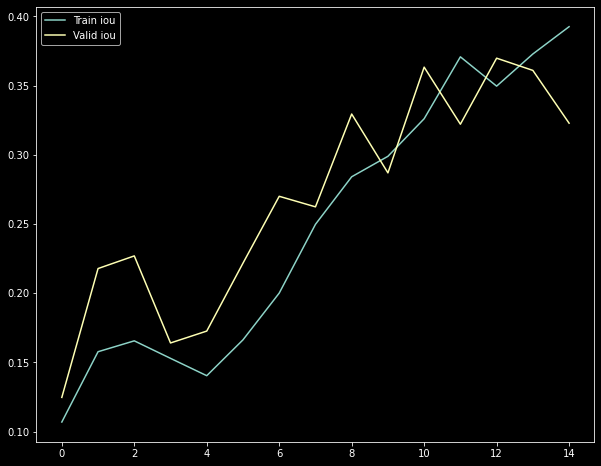

In [292]:
plt.figure(figsize=(10,8))
plt.plot(train_iou, label='Train iou')
plt.plot(valid_iou, label='Valid iou')
plt.legend()

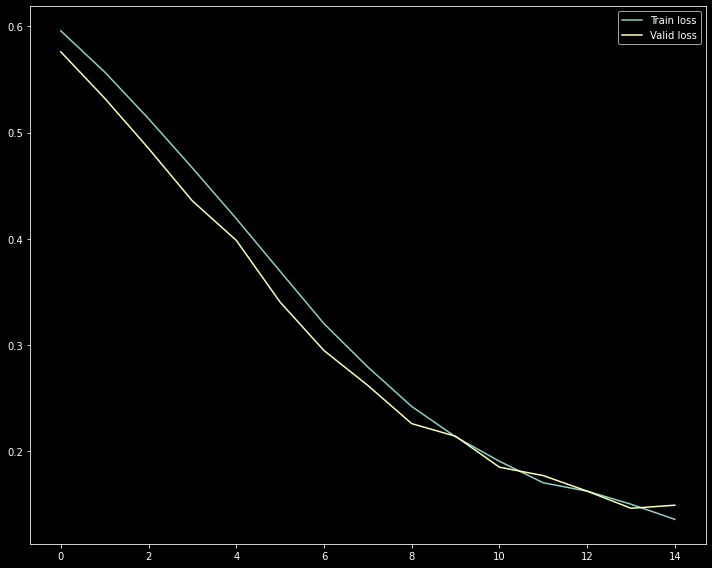

In [293]:
l = []
for i in train_loss :
  l.append(i.detach().numpy())
plt.figure(figsize=(10,8))
plt.plot(l, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()
plt.tight_layout()
plt.show()

## Visualize the models output on 4 of target images (5%)

Run the model on 4 samples from the target set. Visualize the outcome by plotting the groud-truth labels, model's predicition, and the difference between them.

1.0
(224, 224, 3)
1.0
(224, 224, 3)
1.0
(224, 224, 3)
1.0
(224, 224, 3)
1.0
(224, 224, 3)


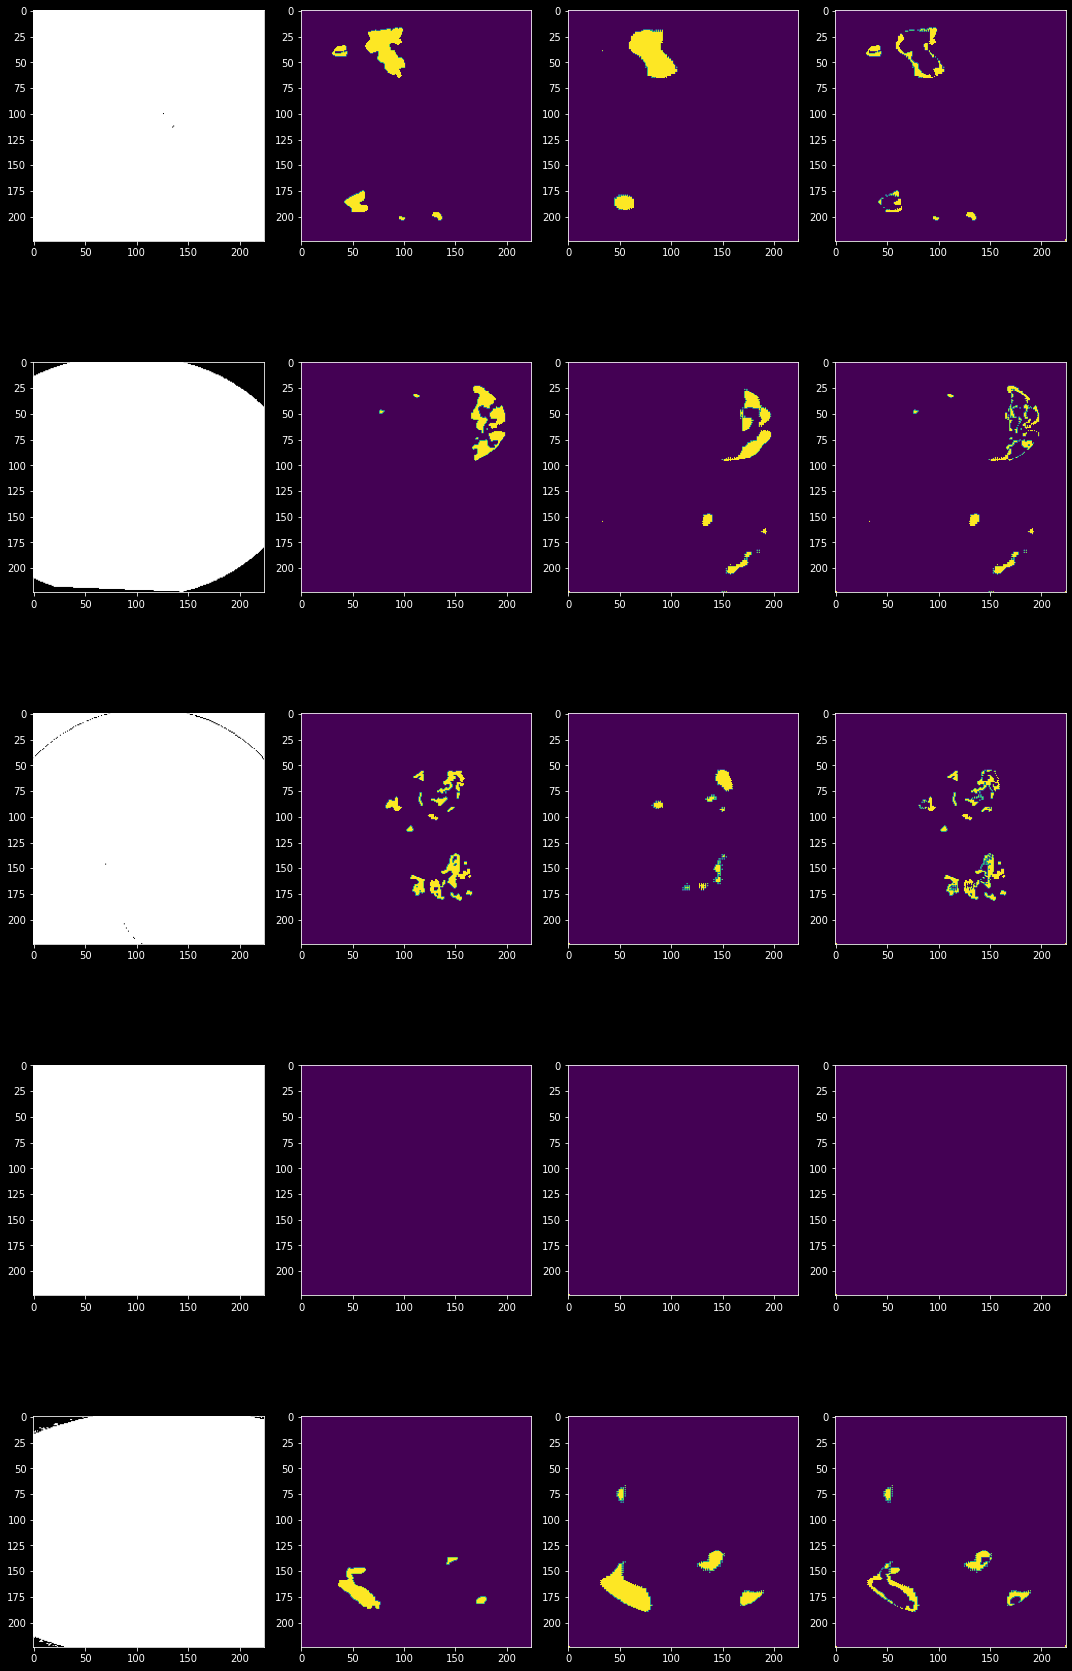

accuracy test time = 0.9850964546203613
Iou test time = 0.43545221198852485


In [296]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    img = img.transpose((1,2,0))
    return img

def compare_diffrence(predb, yb,i):
    img = yb[i][0]!=predb[i][0]
    return img

def test(model, test_loader):
  xb, yb = next(iter(test_loader))
  with torch.no_grad():
    predb = model(xb)
  bs = batch_size
  fig, ax = plt.subplots(bs,4, figsize=(15,bs*5))
  predb = make_binary(predb)
  for i in range(bs):
      ax[i,0].imshow(batch_to_img(xb,i))
      ax[i,1].imshow(yb[i][0])
      ax[i,2].imshow((predb)[i][0])
      ax[i,3].imshow(compare_diffrence(predb, yb,i))
  plt.tight_layout()
  plt.show()
  acc = acc_metric(predb, yb)
  print("accuracy test time = "+str(float(acc)))
  iou = iou_metric(predb, yb)
  print("Iou test time = "+str(iou))
  
test (unet, test_loader)

## Improve U-Net (Bonus) (10%)

In this bnous part, you can add your ideas for improving your model's performance. As an idea, you can search about exploiting IOU metric in the loss function. (you may use other ideas as well!) 

In [ ]:
# TODO: Improve U-NET